# Edmontonian - A Data Analysis of Urban Sprawl and Population

### Introduction

The City of Edmonton is the capital of the Canadian province of Alberta and is home to about 1 million residents. Covering an area of approximately 767 square kilometres across 400 neighbourhoods, the population density is 1215 per square kilometre [1][2]. As a new resident of Edmonton, I choose to study Edmonton for this project.

The population density of Edmonton is one of the lowest of Canada's major cities. This seems to continue decreasing, where the city recently acquired 82.6 sq-km in low populace towns of Leduc County and the City of Beaumont in 2019 [1].
This low population density is a strong indicator of urban sprawl. This term is synonymous with many, many urban issues, such as increasing commuting time, increasing social isolation, decreasing farmland availability, increasing distance to access social venues, and an overall stress on sustainability. Not only does this put a large financial strain for the city, the costs will be shared with the residents in increasing property taxes, utility fees, road maintenance, infrastructure upgrades and social services. However, it is difficult to obtain the information to guide city planners, investors, and prospective residents towards a sustainable solution.

In consideration of these problems and to guide city planners and investors toward city densification, this project will use maps and charts to investigate the unique venue types and age groups clustered by neighbourhoods in Edmonton.

[1] Edmonton, Wikipedia https://en.wikipedia.org/wiki/Edmonton
[2] City of Edmonton open datasets

### Data
- To process the data, IBM Watson Studio platform is used to express the Python language to process the data.
- For data of the most common venues per neighbourhood, Foursquare API is used.
- For Edmonton data, the city has published publicly available datasets using JSON format. https://data.edmonton.ca/browse
    - used for data on age groups
    - used for latitude/longitude of the centroid of neighbourhoods

### Code

In [1]:
#Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge lxml --yes
import lxml   # web table reading library

#geopandas
!conda install -c conda-forge descartes --yes
!conda install -c conda-forge geopandas --yes
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

### Download and Explore dataset

Import data for Edmonton neighbourhoods, with lat/long:

In [91]:
#geolocation of Edmonton
address = 'Edmonton, Alberta'

geolocator = Nominatim(user_agent = 'my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Edmonton, AB are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Edmonton, AB are 53.535411, -113.507996.


In [2]:
import requests
url_nbh = 'https://data.edmonton.ca/api/views/3b6m-fezs/rows.json?accessType=DOWNLOAD'
resp = requests.get(url_nbh)
txt = resp.json()
df_nbh = pd.DataFrame(txt['data'])
df_nbh.head()
#data pulled to grab neighbourhoods with lat/long of centroids

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,row-q2s3~rne6-35am,00000000-0000-0000-94B0-676367940AD7,0,1564340464,None,1564340469,None,{ },4477,Kinglet Gardens,2.637128925787492,53.57737927243443,-113.70141746036136,"[{""address"": """", ""city"": """", ""state"": """", ""zip...",301,137,3,1,1,195,1,None
1,row-khft_hg55_sh8m,00000000-0000-0000-6330-18F6A2E32D9D,0,1580673667,None,1580673668,None,{ },4018,Anthony Henday Big Lake,3.217870432659547,53.59221129676067,-113.64788090698353,"[{""address"": """", ""city"": """", ""state"": """", ""zip...",312,53,3,1,1,10,1,None
2,row-4tvp.xbd9~u5m5,00000000-0000-0000-04C1-38815877B49C,0,1580673667,None,1580673668,None,{ },6492,Mill Creek Ravine South,0.7586052039226456,53.50771159416601,-113.46483608342514,"[{""address"": """", ""city"": """", ""state"": """", ""zip...",157,67,7,5,3,242,11,None
3,row-5ufg_yssq-cbey,00000000-0000-0000-A4EC-3C896CFC45A1,0,1580673667,None,1580673668,None,{ },4023,Anthony Henday Rampart,3.15032303875196,53.62763458998669,-113.57620317573685,"[{""address"": """", ""city"": """", ""state"": """", ""zip...",379,60,1,1,5,17,2,None
4,row-g4i3~n8mu.4bck,00000000-0000-0000-9CA6-4F98AA9A0CB4,0,1580673667,None,1580673668,None,{ },3220,Hagmann Estate Industrial,0.5277698169140193,53.58217611124326,-113.54495066304352,"[{""address"": """", ""city"": """", ""state"": """", ""zip...",183,107,3,1,5,162,2,None


In [3]:
#select columns wanted
df_nbh1 = df_nbh[[8,9,10,11,12]]
df_nbh1.head()
#alternative to choosing the columns, can drop columns
#df2 = df_nbh.drop([0,1,2,3,4,5,6,7,13,14,15,16,17,18,19,20,21], axis=1)
#df2.head()

,8,9,10,11,12
0,4477,Kinglet Gardens,2.637128925787492,53.57737927243443,-113.70141746036136
1,4018,Anthony Henday Big Lake,3.217870432659547,53.59221129676067,-113.64788090698353
2,6492,Mill Creek Ravine South,0.7586052039226456,53.50771159416601,-113.46483608342514
3,4023,Anthony Henday Rampart,3.15032303875196,53.62763458998669,-113.57620317573685
4,3220,Hagmann Estate Industrial,0.5277698169140193,53.58217611124326,-113.54495066304352


In [4]:
#rename column heads
df_nbhll = df_nbh1.rename(columns = {8:'Number',9:'Neighbourhood',10:'Sq-km',11:'Latitude',12:'Longitude'}, inplace = False)
df_nbhll.head()

,Number,Neighbourhood,Sq-km,Latitude,Longitude
0,4477,Kinglet Gardens,2.637128925787492,53.57737927243443,-113.70141746036136
1,4018,Anthony Henday Big Lake,3.217870432659547,53.59221129676067,-113.64788090698353
2,6492,Mill Creek Ravine South,0.7586052039226456,53.50771159416601,-113.46483608342514
3,4023,Anthony Henday Rampart,3.15032303875196,53.62763458998669,-113.57620317573685
4,3220,Hagmann Estate Industrial,0.5277698169140193,53.58217611124326,-113.54495066304352


Add population information.

In [5]:
#data is as of April 1, 2019.
url_age = 'https://data.edmonton.ca/api/views/a6zx-dzqn/rows.json?accessType=DOWNLOAD'
reqs = requests.get(url_age)
txt = reqs.json()
df_age = pd.DataFrame(txt['data'])
df_age.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,row-ccg3.wwdj.smtq,00000000-0000-0000-01C4-1FC0D4777B08,0,1568132593,None,1568132593,None,{ },Ward 2,1230,Spruce Avenue,45-49,93
1,row-kqgw_vmf5~5m49,00000000-0000-0000-E710-FCFF2ECEC5B9,0,1568132593,None,1568132593,None,{ },Ward 4,2720,York,45-49,159
2,row-v72s_n5yf-ez5s,00000000-0000-0000-40A5-7320DEFBF625,0,1568132593,None,1568132593,None,{ },Ward 8,6710,Strathearn,55-59,161
3,row-nydm-6y44_ynf3,00000000-0000-0000-4A19-0C95B93DB317,0,1568132593,None,1568132593,None,{ },Ward 5,4140,Elmwood,65-69,126
4,row-xzwu_py7e.z2d5,00000000-0000-0000-0098-41E5AD81815C,0,1568132593,None,1568132593,None,{ },Ward 8,5370,River Valley Mayfair,45-49,0


In [6]:
#select relevant columns and rename
df_age1 = df_age[[9,10,11,12]]
df_age2 = df_age1.rename(columns = 
 {9:'Number',10:'Neighbourhood',11:'AgeGroup',12:'Population'}, inplace = False)
df_age2.sort_values(by=['Neighbourhood','AgeGroup']).head(20)

,Number,Neighbourhood,AgeGroup,Population
6317,2010,Abbottsfield,0-4,140
6059,2010,Abbottsfield,10-14,155
2659,2010,Abbottsfield,15-19,110
6452,2010,Abbottsfield,20-24,95
2708,2010,Abbottsfield,25-29,108
7067,2010,Abbottsfield,30-34,128
3065,2010,Abbottsfield,35-39,142
5500,2010,Abbottsfield,40-44,117
296,2010,Abbottsfield,45-49,91
3647,2010,Abbottsfield,5-9,164


Lets group AgeGroup differently to have fewer age ranges.

In [7]:
#create a function to translate data:
agechild = ['0-4','5-9','10-14']
ageadult0 =['15-19','20-24']
ageadult1 =['25-29','30-34']
ageadult2 =['35-39','40-44']
ageadult3 =['45-49','50-54','55-59']
ageelder1=['60-64','65-69','70-74']
ageelder2=['75-79','80-84','85+']

def age_group (row):
    if row['AgeGroup'] in agechild: return '00-14'
    elif row['AgeGroup'] in ageadult0: return '15-24'
    elif row['AgeGroup'] in ageadult1: return '25-34'
    elif row['AgeGroup'] in ageadult2: return '35-44'
    elif row['AgeGroup'] in ageadult3: return '45-59'
    elif row['AgeGroup'] in ageelder1: return '60-74'
    elif row['AgeGroup'] in ageelder2: return '75+'
    return 'Other'

In [8]:
#create new column called df_age2.AgeCategory
df_age2['AgeCategory'] = df_age2.apply(lambda row: age_group(row), axis=1)

In [9]:
df_age2.head()

,Number,Neighbourhood,AgeGroup,Population,AgeCategory
0,1230,Spruce Avenue,45-49,93,45-59
1,2720,York,45-49,159,45-59
2,6710,Strathearn,55-59,161,45-59
3,4140,Elmwood,65-69,126,60-74
4,5370,River Valley Mayfair,45-49,0,45-59


In [10]:
#drop rows if contains Other, drop column AgeGroup for simplicity
df_age3 = df_age2.drop('AgeGroup', axis=1)
df_age3.sort_values(by=['Neighbourhood','AgeCategory']).head()

,Number,Neighbourhood,Population,AgeCategory
3647,2010,Abbottsfield,164,00-14
6059,2010,Abbottsfield,155,00-14
6317,2010,Abbottsfield,140,00-14
2659,2010,Abbottsfield,110,15-24
6452,2010,Abbottsfield,95,15-24


In [11]:
df_age4 = df_age3[df_age3.AgeCategory != 'Other']
df_age4.sort_values(by=['Neighbourhood','AgeCategory']).head()

,Number,Neighbourhood,Population,AgeCategory
3647,2010,Abbottsfield,164,00-14
6059,2010,Abbottsfield,155,00-14
6317,2010,Abbottsfield,140,00-14
2659,2010,Abbottsfield,110,15-24
6452,2010,Abbottsfield,95,15-24


In [12]:
df_age4.dtypes
#need to convert Population from object to int

Number           object
Neighbourhood    object
Population       object
AgeCategory      object
dtype: object

In [13]:
df_age4['Popn'] = df_age4['Population'].astype(str).astype(int)
df_age4


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Number,Neighbourhood,Population,AgeCategory,Popn
0,1230,Spruce Avenue,93,45-59,93
1,2720,York,159,45-59,159
2,6710,Strathearn,161,45-59,161
3,4140,Elmwood,126,60-74,126
4,5370,River Valley Mayfair,0,45-59,0
5,5405,River Valley Windermere,0,00-14,0
6,5160,Duggan,227,60-74,227
7,3210,Grovenor,122,00-14,122
8,2660,Rundle Heights,189,00-14,189
9,5401,River Valley Fort Edmonton,0,25-34,0


In [14]:
df_age4.dtypes
#okay, popn is now int

Number           object
Neighbourhood    object
Population       object
AgeCategory      object
Popn              int64
dtype: object

In [15]:
#df_nbhpop = neighbourhood populations
df_nbhpop = df_age4.groupby(['Number','Neighbourhood'])['Popn'].sum().reset_index()
df_nbhpop.sort_values(by=['Neighbourhood']).head()

,Number,Neighbourhood,Popn
24,2010,Abbottsfield,1537
127,3460,Albany,1349
0,1010,Alberta Avenue,4859
131,4010,Alberta Park Industrial,0
141,4020,Aldergrove,4749


In [16]:
#df_nbhage = neighbourhood population by age
df_nbhage = df_age4.groupby(['Number','Neighbourhood','AgeCategory'])['Popn'].sum().reset_index()
df_nbhage.sort_values(by=['Neighbourhood','AgeCategory']).head()

,Number,Neighbourhood,AgeCategory,Popn
168,2010,Abbottsfield,00-14,459
169,2010,Abbottsfield,15-24,205
170,2010,Abbottsfield,25-34,236
171,2010,Abbottsfield,35-44,259
172,2010,Abbottsfield,45-59,211


In [17]:
#merge df_nbhage and df_nbhll
df_edm_age = pd.merge(df_nbhage, df_nbhll, on =['Number','Neighbourhood'], how='inner')
df_edm_age.head()

,Number,Neighbourhood,AgeCategory,Popn,Sq-km,Latitude,Longitude
0,1010,Alberta Avenue,00-14,716,1.680470552960205,53.56848538240247,-113.48511916925099
1,1010,Alberta Avenue,15-24,515,1.680470552960205,53.56848538240247,-113.48511916925099
2,1010,Alberta Avenue,25-34,770,1.680470552960205,53.56848538240247,-113.48511916925099
3,1010,Alberta Avenue,35-44,826,1.680470552960205,53.56848538240247,-113.48511916925099
4,1010,Alberta Avenue,45-59,1047,1.680470552960205,53.56848538240247,-113.48511916925099


In [18]:
#merge df_nbhpop and df_nbhll
df_edm_pop = pd.merge(df_nbhpop, df_nbhll, on =['Number','Neighbourhood'], how='inner')
df_edm_pop.head()

,Number,Neighbourhood,Popn,Sq-km,Latitude,Longitude
0,1010,Alberta Avenue,4859,1.680470552960205,53.56848538240247,-113.48511916925099
1,1020,Boyle Street,4489,0.8813521475154773,53.54763098241901,-113.47926288099585
2,1030,Central McDougall,3557,1.20211693816118,53.553331828524456,-113.50106809472395
3,1070,Cromdale,1604,0.35887938406231884,53.55906091693039,-113.46904309070749
4,1080,Delton,1701,0.6798065380985228,53.57904638464889,-113.48244944665866


### Pull Foursquare data

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
# The code was removed by Watson Studio for sharing.

Your Foursquare API credentials:
CLIENT_ID_B: your client ID
CLIENT_SECRET_B: your client secret


In [21]:
def getNearbyPlaces(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [22]:
edm_venues = getNearbyPlaces(names=df_edm_pop['Neighbourhood'],
                            latitudes=df_edm_pop['Latitude'],
                            longitudes=df_edm_pop['Longitude']
                            )

Found 1685 venues in 398 neighborhoods.


In [23]:
#continue from approx half-way of 'Cluster Toronto'.
#do a one-hot analysis of age groups, to get age group distrn.
#do a one-hot analysis of the venues, to get venue probability.
#Neighbourhoods preview  : https://data.edmonton.ca/Census/2019-Census-Population-by-Age-Range-Neighbourhood-/a6zx-dzqn/data
#AgeGroup by nbh preview : https://data.edmonton.ca/City-Administration/City-of-Edmonton-Neighbourhoods-Centroid-Point-/3b6m-fezs/data
#use the bookmarks on DELL LAPTOP to explore query clustering.

In [35]:
#onehot encoding
edm_onehot = pd.get_dummies(edm_venues[['Venue Category']],prefix="",prefix_sep="")
#edm_onehot.head() #for testing
edm_onehot['Neighbourhood'] = edm_venues['Neighborhood']
#move column "Neighbourhood" to the first column:
fixed_columns = [edm_onehot.columns[-1]] + list(edm_onehot.columns[:-1])
edm_onehot = edm_onehot[fixed_columns]
edm_onehot.head()
#each row is now characterized as 1 or 0.

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Campground,Candy Store,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,College Academic Building,College Gym,College Residence Hall,College Theater,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Agency,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Alberta Avenue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
#group neighbourhoods and take the mean of frequency per category per neighbourhood.
edmvenue_grouped = edm_onehot.groupby('Neighbourhood').mean().reset_index()
edmvenue_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Campground,Candy Store,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,College Academic Building,College Gym,College Residence Hall,College Theater,Comedy Club,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Event Service,Event Space,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Rental Service,Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Travel Agency,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Abbottsfield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0

### Find the top 5 venues per neighbourhood.

In [38]:
topX_venues = 5

#define rank function 'hood', since rank is a function
for hood in edmvenue_grouped['Neighbourhood']: 
    print("-----"+hood+'-----')
    temp = edmvenue_grouped[edmvenue_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':3})
    print(temp.sort_values('freq',ascending=False).reset_index(drop=True).head(topX_venues))
    print('\n')

-----Abbottsfield-----
                   venue  freq
0      Convenience Store   0.5
1            Bus Station   0.5
2      Accessories Store   0.0
3  Outdoors & Recreation   0.0
4   Outdoor Supply Store   0.0


-----Albany-----
            venue  freq
0  Discount Store   0.2
1     Pizza Place   0.2
2   Shopping Mall   0.2
3   Big Box Store   0.2
4      Restaurant   0.2


-----Alberta Avenue-----
           venue   freq
0         Bakery  0.143
1    Music Venue  0.143
2           Café  0.143
3    Gas Station  0.143
4  Hot Dog Joint  0.143


-----Alberta Park Industrial-----
                        venue   freq
0  Construction & Landscaping  0.333
1                Home Service  0.111
2      Furniture / Home Store  0.111
3                  Print Shop  0.111
4            Business Service  0.111


-----Aldergrove-----
                   venue   freq
0                    Pub  0.333
1          Hot Dog Joint  0.333
2       Asian Restaurant  0.333
3           Optical Shop  0.000
4  Outdoors & Re

In [39]:
#put into pandas dataframe, sorted descending
def return_most_common_venues(row, topX_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:topX_venues]

In [41]:
#create new df to display top 5 venues per neighbourhood
topX_venues = 5
#suffix_list = ['st','nd','rd'] #for labelling 1st, 2nd, 3rd for... will exclude.

#...columns according to top venues. A ranking.
columns = ['Neighbourhood']
for ranker in np.arange(topX_venues):    # realpython.com/how-to-use-numpy-arange/
    columns.append('Most Common Venue Rank {}'.format(ranker+1)) # +1 since the list since it starts at 0.
    #try:    columns.append('{}{} Most Common Venue'.format(ranker+1, suffix_list[ranker]))
    #except: columns.append('{}th Most Common Venue'.format(suffix_list[ranker+1]))
    
#new dataframe
edmvenues_sorted = pd.DataFrame(columns=columns)
edmvenues_sorted['Neighbourhood'] = edmvenue_grouped['Neighbourhood']

for ranker in np.arange(edmvenue_grouped.shape[0]):
    edmvenues_sorted.iloc[ranker, 1:] = return_most_common_venues(edmvenue_grouped.iloc[ranker, 1:], topX_venues)
    
edmvenues_sorted

,Neighbourhood,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5
0,Abbottsfield,Convenience Store,Bus Station,Fried Chicken Joint,Fish & Chips Shop,Flower Shop
1,Albany,Discount Store,Restaurant,Pizza Place,Big Box Store,Shopping Mall
2,Alberta Avenue,Bakery,Pharmacy,Music Venue,Café,Hot Dog Joint
3,Alberta Park Industrial,Construction & Landscaping,Furniture / Home Store,Home Service,Electronics Store,Print Shop
4,Aldergrove,Pub,Hot Dog Joint,Asian Restaurant,Zoo,French Restaurant
5,Allard,Construction & Landscaping,Pizza Place,Coffee Shop,Garden Center,Gaming Cafe
6,Allendale,Board Shop,Chinese Restaurant,Hotpot Restaurant,Zoo,Flower Shop
7,Ambleside,Coffee Shop,Thai Restaurant,Gastropub,Juice Bar,Park
8,Anthony Henday Big Lake,Scenic Lookout,Zoo,Fast Food Restaurant,Gas Station,Garden Center
9,Anthony Henday South Blackburne,Convenience Store,Insurance Office,Fried Chicken Joint,Fish & Chips Shop,Flower Shop


In [47]:
### join edmvenues_sorted and df_edm_pop (and later, df_edm_age)

edm_popn_venues = pd.merge(df_edm_pop, edmvenues_sorted, on=['Neighbourhood'])
edm_popn_venues.sort_values(by='Popn', ascending=True).reset_index()

,index,Number,Neighbourhood,Popn,Sq-km,Latitude,Longitude,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5
0,166,4490,Sheffield Industrial,0,0.3796837855747157,53.56081597101263,-113.5965957203426,Pub,Outdoor Supply Store,Gas Station,Coffee Shop,Speakeasy
1,168,4510,Stone Industrial,0,0.6458614560348406,53.54495821926104,-113.62167138133896,Fast Food Restaurant,Electronics Store,Chinese Restaurant,Automotive Shop,Grocery Store
2,331,6780,Weir Industrial,0,1.6353033793368414,53.511765061429585,-113.40610727547318,Breakfast Spot,Café,Zoo,Fried Chicken Joint,Flower Shop
3,160,4467,River Valley Cameron,0,2.0260588656845595,53.47235679378515,-113.61607674174749,Airport Lounge,Zoo,Fried Chicken Joint,Fish & Chips Shop,Flower Shop
4,316,6620,River Valley Gold Bar,0,2.070699262094262,53.552270074281466,-113.43756821133056,Dance Studio,Trail,Shop & Service,Zoo,Food Truck
5,157,4451,River Valley Oleskiw,0,2.4730859497546147,53.48885107431074,-113.60142818286619,Golf Course,Trail,Zoo,French Restaurant,Fish & Chips Shop
6,156,4440,River Valley Lessard North,0,0.7942002710867325,53.504195315820766,-113.58482691728696,Bakery,Hotel,Theater,Golf Course,Café
7,154,4400,Place LaRue,0,1.0417995561251951,53.539007704860055,-113.6333234164309,Hotel,Pizza Place,Vietnamese Restaurant,Bar,Restaurant
8,150,4350,Norwester Industrial,0,0.6881476038838065,53.56673770424075,-113.60888372765902,Sandwich Place,Farmers Market,Gas Station,Garden Center,Gaming Cafe
9,149,4340,Morin Industrial,0,0.6686128098042238,53.54492070023586,-113.63360526712503,Gym,Furniture / Home Store,Ice Cream Shop,Hotel,Zoo


In [66]:
edm_popn_venues.dtypes

Neighbourhood               object
Sq-km                       object
Popn                         int64
PopDensity                  object
Latitude                    object
Longitude                   object
Most Common Venue Rank 1    object
Most Common Venue Rank 2    object
Most Common Venue Rank 3    object
Most Common Venue Rank 4    object
Most Common Venue Rank 5    object
dtype: object

In [80]:
#and! here we can add new columns with popn density:
edm_popn_venues['Sq-km'] = edm_popn_venues['Sq-km'].astype(object).astype(float)
edm_popn_venues['Latitude'] = edm_popn_venues['Latitude'].astype(object).astype(float)
edm_popn_venues['Longitude'] = edm_popn_venues['Longitude'].astype(object).astype(float)
edm_popn_venues['PopDensity'] = edm_popn_venues['Popn'] / edm_popn_venues['Sq-km']
edm_popn_venues2 = edm_popn_venues[['Neighbourhood','Popn','Sq-km','PopDensity','Latitude','Longitude',
                             'Most Common Venue Rank 1',
                             'Most Common Venue Rank 2',
                             'Most Common Venue Rank 3',
                             'Most Common Venue Rank 4',
                             'Most Common Venue Rank 5']]
edm_popn_venues2.sort_values(by='PopDensity', ascending=True).reset_index()

,index,Neighbourhood,Popn,Sq-km,PopDensity,Latitude,Longitude,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5
0,166,Sheffield Industrial,0,0.379684,0.000000,53.560816,-113.596596,Pub,Outdoor Supply Store,Gas Station,Coffee Shop,Speakeasy
1,149,Morin Industrial,0,0.668613,0.000000,53.544921,-113.633605,Gym,Furniture / Home Store,Ice Cream Shop,Hotel,Zoo
2,148,Mitchell Industrial,0,0.592507,0.000000,53.574016,-113.584201,Furniture / Home Store,Shop & Service,Zoo,Fast Food Restaurant,Gas Station
3,147,Mistatim Industrial,0,6.780328,0.000000,53.596837,-113.599771,Coffee Shop,Dog Run,Golf Course,Rental Service,French Restaurant
4,145,McNamara Industrial,0,0.978108,0.000000,53.554078,-113.621277,Restaurant,Breakfast Spot,Bank,Dessert Shop,Fast Food Restaurant
5,279,Gainer Industrial,0,0.342465,0.000000,53.516111,-113.424517,Coffee Shop,Breakfast Spot,Candy Store,Luggage Store,Restaurant
6,280,Girard Industrial,0,0.497381,0.000000,53.511170,-113.437724,Pub,Hotel,Furniture / Home Store,Casino,Gym / Fitness Center
7,138,High Park Industrial,0,0.388799,0.000000,53.561040,-113.584248,Fast Food Restaurant,Yoga Studio,Coffee Shop,Chinese Restaurant,Latin American Restaurant
8,136,Hawin Park Estate Industrial,0,0.678200,0.000000,53.574851,-113.596574,Construction & Landscaping,Mobile Phone Shop,Electronics Store,Fruit & Vegetable Store,Flower Shop
9,134,Garside Industrial,0,0.664488,0.000000,53.566750,-113.584178,Electronics Store,Shop & Service,Furniture / Home Store,French Restaurant,Fish & Chips Shop


In [82]:
edm_popn_venues2.dtypes

Neighbourhood                object
Popn                          int64
Sq-km                       float64
PopDensity                  float64
Latitude                    float64
Longitude                   float64
Most Common Venue Rank 1     object
Most Common Venue Rank 2     object
Most Common Venue Rank 3     object
Most Common Venue Rank 4     object
Most Common Venue Rank 5     object
dtype: object

We already see that there are 81 of 400 (20%) neighbourhoods with 0 population, and 90 of 400 (22.5%) with under 500 persons/sq-km. This likely indicates commuting is required, and near worksites, likely industrial zones.

## Cluster Edmonton Neighbourhoods using k-means

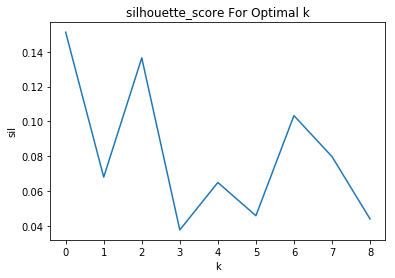

the optimal k is 0


In [95]:
#Silhouette score

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

edm_popn_venues2_clustering = edmvenue_grouped.drop('Neighbourhood', 1)
sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=5).fit(edm_popn_venues2_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(edm_popn_venues2_clustering, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xlabel('k')
plt.ylabel('sil')
plt.title('silhouette_score For Optimal k')
plt.show()
print('the optimal k is', sil.index(max(sil)))

In [96]:
#set number of clusters. Looks like 2 clusters is optimal (next to zero)
kclusters = 2
edm_clusters1 = edmvenue_grouped.drop('Neighbourhood',1)
#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(edm_clusters1)

#check cluster labels genereated per row in df

kmeans.labels_

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Create a new df including cluster as well as top 5 venues per neighbourhood.

In [97]:
#add cluster labels
edm_popn_venues2['Cluster Label'] = kmeans.labels_
edm_popn_venues2.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Popn,Sq-km,PopDensity,Latitude,Longitude,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5,Cluster Label
0,Alberta Avenue,4859,1.680471,2891.452035,53.568485,-113.485119,Bakery,Pharmacy,Music Venue,Café,Hot Dog Joint,0
1,Boyle Street,4489,0.881352,5093.310333,53.547631,-113.479263,Bar,Café,Chinese Restaurant,Grocery Store,Vietnamese Restaurant,0
2,Central McDougall,3557,1.202117,2958.946744,53.553332,-113.501068,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Historic Site,Food & Drink Shop,0
3,Cromdale,1604,0.358879,4469.468215,53.559061,-113.469043,Fast Food Restaurant,Sandwich Place,Bus Station,Light Rail Station,Physical Therapist,0
4,Delton,1701,0.679807,2502.182466,53.579046,-113.482449,Restaurant,Italian Restaurant,Business Service,Beach,Zoo,0
5,Downtown,10070,2.309268,4360.688346,53.539767,-113.499421,Sandwich Place,Coffee Shop,Hotel,Italian Restaurant,French Restaurant,1
6,Eastwood,2695,1.131892,2380.968694,53.576105,-113.468730,Grocery Store,Department Store,Fried Chicken Joint,Fish & Chips Shop,Flower Shop,0
7,Blatchford Area,0,3.055364,0.000000,53.571985,-113.516997,Airport Lounge,Chinese Restaurant,Coffee Shop,Zoo,French Restaurant,0
8,Edmonton Northlands,0,0.752915,0.000000,53.568372,-113.456446,Bar,Hockey Arena,Inn,Racetrack,Music Venue,0
9,Elmwood Park,856,0.479574,1784.916280,53.579591,-113.460917,Hotel,Motorcycle Shop,Karaoke Bar,Furniture / Home Store,Asian Restaurant,0


In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(edm_popn_venues2['Latitude'], edm_popn_venues2['Longitude'], edm_popn_venues2['Neighbourhood'], edm_popn_venues2['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [100]:
edm_popn_venues2.loc[edm_popn_venues2['Cluster Label'] == 1, edm_popn_venues2.columns[[0] + list(range(5, edm_popn_venues2.shape[1]))]].reset_index()

,index,Neighbourhood,Longitude,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5,Cluster Label
0,5,Downtown,-113.499421,Sandwich Place,Coffee Shop,Hotel,Italian Restaurant,French Restaurant,1
1,12,Parkdale,-113.471350,Vietnamese Restaurant,Fried Chicken Joint,Fish & Chips Shop,Flower Shop,Food & Drink Shop,1
2,40,Fraser,-113.374782,Pub,French Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,1
3,49,Kildare,-113.455150,Recreation Center,Zoo,French Restaurant,Filipino Restaurant,Fish & Chips Shop,1
4,58,McConachie Area,-113.431312,Construction & Landscaping,Gas Station,Fried Chicken Joint,Fish & Chips Shop,Flower Shop,1
5,60,Miller,-113.411106,Pharmacy,Pizza Place,Vietnamese Restaurant,Zoo,Fish & Chips Shop,1
6,83,Chambery,-113.511761,Construction & Landscaping,Baseball Field,Playground,Fried Chicken Joint,Flower Shop,1
7,92,Hagmann Estate Industrial,-113.544951,Pub,Breakfast Spot,Middle Eastern Restaurant,Convenience Store,Gas Station,1
8,103,Prince Charles,-113.536002,Bus Station,Zoo,Filipino Restaurant,Gastropub,Gas Station,1
9,110,Sherbrooke,-113.547286,Record Shop,Lawyer,Sandwich Place,Zoo,Food Truck,1


There are 19 neighbourhoods 

In [101]:
edm_popn_venues2.loc[edm_popn_venues2['Cluster Label'] == 0, edm_popn_venues2.columns[[0] + list(range(5, edm_popn_venues2.shape[1]))]].reset_index()

,index,Neighbourhood,Longitude,Most Common Venue Rank 1,Most Common Venue Rank 2,Most Common Venue Rank 3,Most Common Venue Rank 4,Most Common Venue Rank 5,Cluster Label
0,0,Alberta Avenue,-113.485119,Bakery,Pharmacy,Music Venue,Café,Hot Dog Joint,0
1,1,Boyle Street,-113.479263,Bar,Café,Chinese Restaurant,Grocery Store,Vietnamese Restaurant,0
2,2,Central McDougall,-113.501068,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Historic Site,Food & Drink Shop,0
3,3,Cromdale,-113.469043,Fast Food Restaurant,Sandwich Place,Bus Station,Light Rail Station,Physical Therapist,0
4,4,Delton,-113.482449,Restaurant,Italian Restaurant,Business Service,Beach,Zoo,0
5,6,Eastwood,-113.468730,Grocery Store,Department Store,Fried Chicken Joint,Fish & Chips Shop,Flower Shop,0
6,7,Blatchford Area,-113.516997,Airport Lounge,Chinese Restaurant,Coffee Shop,Zoo,French Restaurant,0
7,8,Edmonton Northlands,-113.456446,Bar,Hockey Arena,Inn,Racetrack,Music Venue,0
8,9,Elmwood Park,-113.460917,Hotel,Motorcycle Shop,Karaoke Bar,Furniture / Home Store,Asian Restaurant,0
9,10,McCauley,-113.485098,Grocery Store,Gift Shop,Café,Bakery,Garden Center,0


# Conclusion

As a preliminary analysis, there are just two clusters.

Cluster Label 1 containers 19 neighbourhoods having a high density of Fried Chicken, Filipino Restaurants, and Flower Shops.

Cluster Label 0 containers 381 neighbourhoods with a varied mixed of venues.

Further analysis shows that 6 of 19 in Cluster 1 had the following low density neighbourhoods (Hagmann Estate Industrial, Anthony Henday Big Lake, Anthony Henday South Blackburne, Place La Rue, Youngstown Industrial, and Southeast Industrial)

This venue and distribution may be too small, and requires further analysis in exploring data relating to a multi-variate study such as urban sprawl. (It may be said that urban sprawl is a "broad" topic.)
